In [65]:
import os
import warnings

import yaml
from sklearn.dummy import DummyClassifier
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

# from sklearn.impute import KNNImputer
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import Normalizer, FunctionTransformer, RobustScaler
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest, shapiro, probplot
import category_encoders as ce
import mlflow
import os
import logging
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

In [83]:
train_data = pd.read_parquet(
    "../data/processed/chrome/08_12_2022/train_set_01_processed.parquet.gzip"
)
# test_data = pd.read_parquet('../data/processed/firefox/08_12_2022/test_set_01_processed.parquet.gzip')
test_data = pd.read_parquet('../data/processed/brave/08_12_2022/test_set_all_processed.parquet.gzip')

In [84]:
del train_data['comb_col_tracker']
del train_data['comb_col_non_tracker']

del test_data['comb_col_tracker']
del test_data['comb_col_non_tracker']

In [85]:
train_data = train_data.iloc[:, 4:]
test_data = test_data.iloc[:, 4:]

In [86]:
for elem in train_data.iloc[:, :-1].columns.values.tolist():
    train_data[f"{elem}_binary"] = np.where(train_data[elem].isnull(), 0, 1)
    test_data[f"{elem}_binary"] = np.where(test_data[elem].isnull(), 0, 1)

In [87]:
# remove all old columns as binary encoding created new columns

train_data = train_data.iloc[:, 150:]
test_data = test_data.iloc[:, 150:]

for elem in train_data.columns.values.tolist():
    train_data[elem] = train_data[elem].astype("uint8")
    test_data[elem] = test_data[elem].astype("uint8")


def label_as_last_column(dataset):
    temp_cols = dataset.columns.tolist()
    index_col = dataset.columns.get_loc("tracker")
    new_col_order = (
            temp_cols[0:index_col]
            + temp_cols[index_col + 1:]
            + temp_cols[index_col: index_col + 1]
    )
    return new_col_order


reordered_cols = label_as_last_column(train_data)
train_data = train_data[reordered_cols]
test_data = test_data[reordered_cols]

In [56]:
def calculate_metrics(data, y_true):
    y_pred = clf.predict(data)
    pred_probs = clf.predict_proba(data)
    score = metrics.log_loss(y_true, pred_probs)
    auc_score = metrics.roc_auc_score(y_true, y_pred)
    f1_score = metrics.f1_score(y_true, y_pred)
    bal_acc = metrics.balanced_accuracy_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    mcc = metrics.matthews_corrcoef(y_true, y_pred)

    print(
        "Model accuracy score : {0:0.4f}".format(metrics.accuracy_score(y_test, y_pred))
    )
    print("Balanced accuracy score : {0:0.4f}".format(bal_acc))
    print("F1 score : {0:0.4f}".format(f1_score))
    print("Model log-loss score : {0:0.4f}".format(score))
    print("Matthews correlation coefficient score : {0:0.4f}".format(mcc))
    print("Precision score : {0:0.4f}".format(precision))
    print("Recall score : {0:0.4f}".format(recall))
    print("Model auc score : {0:0.4f}".format(auc_score))

    print(metrics.classification_report(y_test, y_pred))

    disp_1 = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    disp_2 = metrics.PrecisionRecallDisplay.from_estimator(
        clf, X_test, y_test, name="Random Forest"
    )
    disp_3 = metrics.RocCurveDisplay.from_estimator(clf, X_test, y_test)
    mlflow.log_figure(disp_1.figure_, "cm.png")
    mlflow.log_figure(disp_2.figure_, "prec_recall.png")
    mlflow.log_figure(disp_3.figure_, "roc.png")

In [90]:
X_train, y_train = train_data.iloc[:, :-1], train_data[["tracker"]]
X_test, y_test = test_data.iloc[:, :-1], test_data[["tracker"]]

del train_data
del test_data

In [115]:
# clf = RandomForestClassifier(
#     n_estimators=100,
#     n_jobs=-1,
#     random_state=10,
#     criterion="log_loss",
#     max_features=None,
# )

# clf = DecisionTreeClassifier()
# clf = GradientBoostingClassifier()
# clf = xgb.XGBClassifier()
# clf = lgb.LGBMClassifier(class_weight="balanced")
clf = MLPClassifier()
# clf = LogisticRegression(n_jobs=-1, random_state=10)
# clf = GaussianNB()

In [57]:
# logging.basicConfig(level=logging.WARN)
# logger = logging.getLogger(__name__)
# warnings.filterwarnings("ignore")
#
# with open("../params.yaml", "rb") as f:
#     params = yaml.load(f, yaml.FullLoader)
#
# mlflow.set_tracking_uri(params["ml_flow"]["MLFLOW_TRACKING_URI"])
# os.environ["MLFLOW_TRACKING_USERNAME"] = params["ml_flow"][
#     "MLFLOW_TRACKING_USERNAME"
# ]
# os.environ["MLFLOW_TRACKING_PASSWORD"] = params["ml_flow"][
#     "MLFLOW_TRACKING_PASSWORD"
# ]
#
# mlflow.set_experiment("all_binary_firefox_experiments")
# mlflow.sklearn.autolog()
# mlflow.xgboost.autolog()
# mlflow.lightgbm.autolog()

In [ ]:
# logged_model = 'runs:/c210d5dc13a641f68fd5feff177ebe8b/model'
# # Load model as a PyFuncModel.
# loaded_model = mlflow.pyfunc.load_model(logged_model)

2023/01/31 15:55:49 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under mlflow-artifacts:/f685d6853b564ad39330aba7b7f8b6b9/5d41849b81374e10b9d8890e7b8a42d4/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the tracking store. If logging to a mlflow server via REST, consider upgrading the server version to MLflow 1.7.0 or above. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.
2023/01/31 15:55:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 5d41849b81374e10b9d8890e7b8a42d4. Failed operations: [RestException("INVALID_PARAMETER

Model accuracy score : 0.9299
Balanced accuracy score : 0.9009
F1 score : 0.1124
Model log-loss score : 0.1850
Matthews correlation coefficient score : 0.2182
Precision score : 0.0601
Recall score : 0.8717
Model auc score : 0.9009
              precision    recall  f1-score   support

           0       1.00      0.93      0.96    561788
           1       0.06      0.87      0.11      2875

    accuracy                           0.93    564663
   macro avg       0.53      0.90      0.54    564663
weighted avg       0.99      0.93      0.96    564663



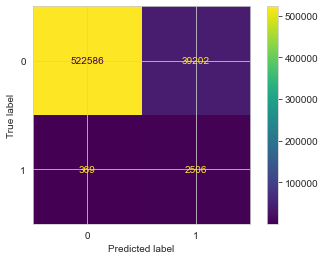

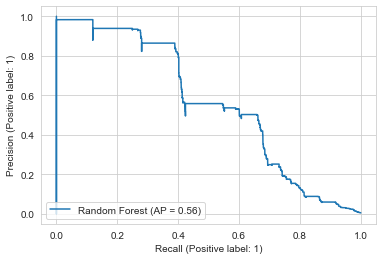

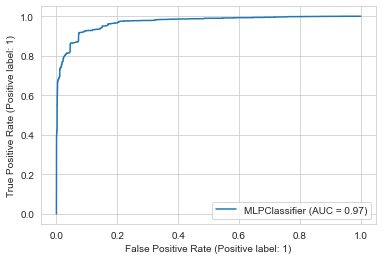

In [116]:
clf.fit(X_train, y_train["tracker"])
calculate_metrics(X_test, y_test)

\footnote{. \url{}, [Accessed Jan. 31, 2023]}

In [118]:
firefox = pd.read_parquet('../data/processed/firefox/08_12_2022/test_set_01_processed.parquet.gzip')

In [119]:
firefox

,hostname,pathname,filetype,filename,date,content-type,content-length,cache-control,content-disposition,etag,...,x-via-ssl,request-time,access-control-request-method,fss-proxy,x-dc,x-llid,x-b3-sampled,tracker,comb_col_non_tracker,comb_col_tracker
0,vuukle.com,/a3a95d10e1d03fe77d6b.png,png,a3a95d10e1d03fe77d6b.png,"fri, 12 aug 2022 22:10:52 gmt",image/webp,15780,"public, max-age=7200","inline; filename=""a3a95d10e1d03fe77d6b.webp""","""a76e19b58c5103936ca99a64e6c1d71d""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,0
1,vuukle.com,/589.1b85456a4e062e8d6232.js,js,589.1b85456a4e062e8d6232.js,"fri, 12 aug 2022 22:10:52 gmt",application/javascript,1539,"public, max-age=7200",NaN,"w/""573591b2d822f76e9fa661dcdc83c284""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,0
2,vuukle.com,/29eab20501ed73f16eba.jpg,jpg,29eab20501ed73f16eba.jpg,"fri, 12 aug 2022 22:10:52 gmt",image/webp,9952,"public, max-age=7200","inline; filename=""29eab20501ed73f16eba.webp""","""97fe776c2cbd2cbaa24192f89eaefc74""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,0
3,vuukle.com,/22ab1ea08fc1962409f1.png,png,22ab1ea08fc1962409f1.png,"fri, 12 aug 2022 22:10:52 gmt",image/webp,41109,"public, max-age=7200","inline; filename=""22ab1ea08fc1962409f1.webp""","""6193272dc9caf2486c404218e1380542""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,0
4,cookie-cdn.cookiepro.com,/scripttemplates/6.19.0/otTCF.js,js,otTCF.js,"fri, 12 aug 2022 22:10:52 gmt",application/javascript,<NA>,"public, max-age=14400",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498363,nt.global.ssl.fastly.net,/images/1431839055959-1428713.jpg,jpg,1431839055959-1428713.jpg,"fri, 12 aug 2022 17:28:58 gmt",image/webp,230,NaN,inline;filename=1428713.jpg;filename*=utf-8''1...,"""lp0kw1rx62w0lmnah1yusy/dyxtczm9x1svbssqydcu""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,0
498364,region1.google-analytics.com,/g/collect,/g/collect,collect,"fri, 12 aug 2022 17:28:58 gmt",text/plain,0,"no-cache, no-store, must-revalidate",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
498365,region1.google-analytics.com,/g/collect,/g/collect,collect,"fri, 12 aug 2022 17:28:58 gmt",text/plain,0,"no-cache, no-store, must-revalidate",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
498366,nt.global.ssl.fastly.net,/images/1431846945741-petworthbeautiesbeautyro...,jpg,1431846945741-petworthbeautiesbeautyroom.jpg,"fri, 12 aug 2022 17:28:58 gmt",image/webp,206,NaN,inline;filename=petworthbeauties_beautyroom.jp...,"""a+x3kgq0g9qfmdlswkdp6yvat8wg4xh1vd6lv4reg+o""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,0


In [121]:
X_test

,pragma_binary,content-type_binary,last-modified_binary,accept-ranges_binary,etag_binary,p3p_binary,x-xss-protection_binary,x-content-type-options_binary,strict-transport-security_binary,x-robots-tag_binary,...,x-amz-meta-codebuild-buildarn_binary,x-amz-meta-codebuild-content-md5_binary,x-llid_binary,x-b3-sampled_binary,x-b3-spanid_binary,x-hubspot-correlation-id_binary,x-hs-target-asset_binary,x-hostname_binary,x-cdn-pop_binary,x-cdn-pop-ip_binary
0,0,1,0,0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564658,0,1,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
564659,0,1,1,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
564660,0,1,1,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
564661,0,1,1,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
